In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rich import print
from scipy.stats import multivariate_normal
from sklearn.datasets import load_sample_image

%load_ext rich

logging.basicConfig(level=logging.INFO)


In [2]:
data = pd.read_csv("./faithful.csv").drop("Unnamed: 0", axis=1)
data

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
...,...,...
267,4.117,81
268,2.150,46
269,4.417,90
270,1.817,46


# Problem 1: K-Means Clustering

## Scatterplot

A visual idenitification shows that the appropriate number of clusters is 2.

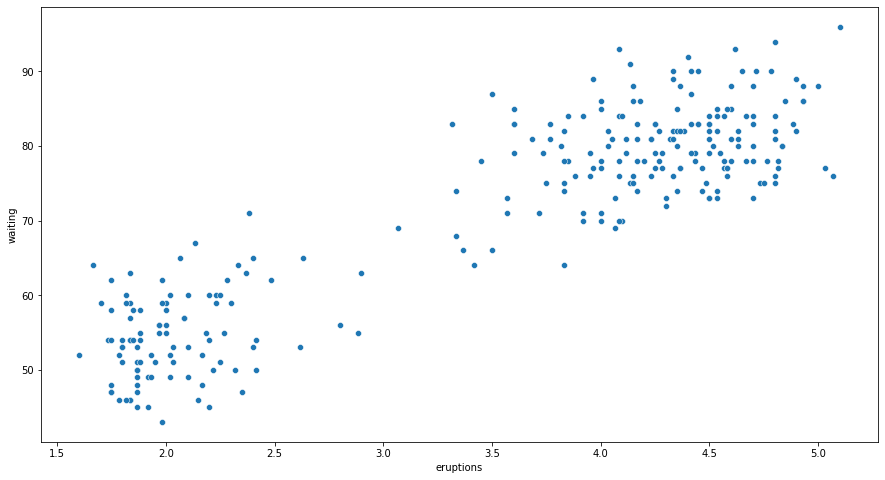

In [3]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=data, x="eruptions", y="waiting")
plt.show()


## K-Means Clustering

Given a set of data points $X = \{x_1, x_2, \ldots, x_n\}$, the K-means clustering algorithm aims to partition the data into $k$ clusters. The algorithm can be summarized as follows:

1. Randomly initialize $k$ cluster centroids and assign each data point to the nearest centroid.
2. Repeat until convergence (i.e., the cluster centroids are no longer changing):
   1. Compute the distance between each data point and each cluster centroid.
   2. For each data point, assign it to the nearest centroid based on the distance computed in the previous step.
   3. Update the cluster centroids to be the mean of the data points assigned to each cluster.
3. Return the cluster centroids and the cluster assignments.

Mathematically, the optimization problem that K-means clustering solves is:
$$
\begin{align*}
\min J = \sum_{n=1}^{N} \sum_{k=1}^{K} r_{nk} ||x_n - \mu_k||^2
\end{align*}
$$

where,
- $N$ is the number of data points,
- $K$ is the number of clusters,
- $r_{nk} = 1$ if data point $x_n$ is assigned to cluster $k$, and $r_{nk} = 0$ otherwise,
- $\mu_k$ is the centroid of cluster $k$.
- $||x_i - \mu_k||^2$ is the squared Euclidean distance between data point $x_i$ and cluster centroid $\mu_k$.

The algorithm starts by randomly initializing the cluster centroids. Then, it iterates between the following two steps until convergence:
1. **Assignment step**: Assign each data point to the nearest cluster centroid.
   $$r_{nk} = \begin{cases} 1 & \text{if } \mu_k \text{ is the closest centroid to } x_n \\ 0 & \text{otherwise} \end{cases}$$

2. **Update step**: Update the cluster centroids to be the mean of the data points assigned to each cluster.
   $$\mu_k = \frac{1}{|C_k|} \sum_{n=1}^{N} r_{nk} x_n$$
   where $C_k$ is the set of data points assigned to cluster $k$.


In [4]:
class KMeans:
    """
    Implementation of the KMeans clustering algorithm.

    Parameters
    ----------
    n_clusters : int
        The number of clusters and centroids to generate.
    max_iter : int
        Maximum number of iterations for the algorithm.
    random_state : int
        Seed for the random number generator.
    debug : bool
        Flag to enable debug logging.

    Attributes
    ----------
    n_clusters : int
        The number of clusters to form as well as the number of centroids to generate.
    max_iter : int
        Maximum number of iterations of the k-means algorithm for a single run.
    random_state : int
        Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.
    debug : bool
        If True, debug information will be logged.
    cluster_centers_ : ndarray
        Coordinates of cluster centers.
    """

    def __init__(self, n_clusters=2, max_iter=100, random_state=42, debug=False):
        """
        Initializes the KMeans clustering algorithm.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.random = np.random.RandomState(self.random_state)
        self._logger = logging.getLogger(self.__class__.__name__)
        self._logger.setLevel(logging.DEBUG if debug else logging.INFO)
        self.cluster_centers_ = None

    def _initialize_centroids(self, X):
        """
        Randomly initializes centroids at the start of the algorithm.

        Parameters
        ----------
        X : ndarray
            The input dataset.
        """
        self._logger.debug("Initializing centroids...")
        random_idx = self.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.cluster_centers_ = X[random_idx]
        self._logger.debug(f"Centroids: {self.cluster_centers_}")

    def _compute_distance(self, X):
        """
        Computes the distance between each point in the dataset and each centroid.

        Parameters
        ----------
        X : ndarray
            The input dataset.

        Returns
        -------
        ndarray
            A 2D array where element (i, j) is the distance between the i-th point and the j-th centroid.
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = np.linalg.norm(X - self.cluster_centers_[i], axis=1)
        return distances

    def _update_centroids(self, X, labels):
        """
        Updates the centroids to the mean of the points assigned to them.

        Parameters
        ----------
        X : ndarray
            The input dataset.
        labels : ndarray
            The labels of each point in X.
        """
        for i in range(self.n_clusters):
            self.cluster_centers_[i] = np.mean(X[labels == i], axis=0)

    def fit(self, X):
        """
        Computes KMeans clustering.

        Parameters
        ----------
        X : ndarray
            The input dataset.
        """
        self._logger.info(f"Fitting KMeans with {self.n_clusters} clusters...")
        self._initialize_centroids(X)
        for i in range(self.max_iter):
            self._logger.debug(f"Iteration {i + 1}")
            centroids = self.cluster_centers_.copy()
            distances = self._compute_distance(X)
            labels = np.argmin(distances, axis=1)
            self._update_centroids(X, labels)
            if np.all(centroids == self.cluster_centers_):
                self._logger.info(f"Converged after {i + 1} iterations")
                break

    def predict(self, X):
        """
        Predicts the closest cluster each sample in X belongs to.

        Parameters
        ----------
        X : ndarray
            The input dataset.

        Returns
        -------
        ndarray
            Index of the cluster each sample belongs to.
        """
        distances = self._compute_distance(X)
        return np.argmin(distances, axis=1)


In [5]:
def plot_kmeans(data, n_clusters, max_iter=100, random_state=42, debug=False):
    """
    Plots the results of KMeans clustering on a 2D dataset.

    Parameters
    ----------
    data : ndarray
        The input dataset, expected to be 2-dimensional.
    n_clusters : int
        The number of clusters to form.
    max_iter : int, optional
        Maximum number of iterations of the KMeans algorithm. Defaults to 100.
    random_state : int, optional
        Determines random number generation for centroid initialization. Use an int for reproducible output. Defaults to 42.
    debug : bool, optional
        If True, debug information will be logged. Defaults to False.
    """
    kmeans = KMeans(
        n_clusters=n_clusters, max_iter=max_iter, random_state=random_state, debug=debug
    )

    kmeans.fit(data)

    data = pd.DataFrame(data, columns=["x", "y"])

    data["cluster"] = kmeans.predict(data)

    plt.figure(figsize=(15, 8))

    sns.scatterplot(
        data=data, x="x", y="y", hue="cluster", palette="tab10", s=50, alpha=0.9
    )

    plt.title(f"KMeans with {n_clusters} clusters")

    plt.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        c="red",
        s=200,
        alpha=0.6,
    )

    plt.show()


INFO:KMeans:Fitting KMeans with 2 clusters...
INFO:KMeans:Converged after 4 iterations


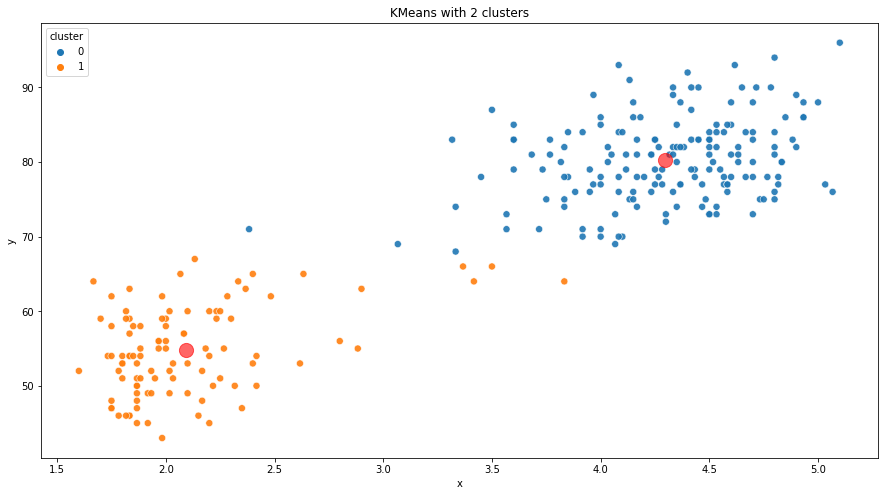

INFO:KMeans:Fitting KMeans with 3 clusters...
INFO:KMeans:Converged after 4 iterations


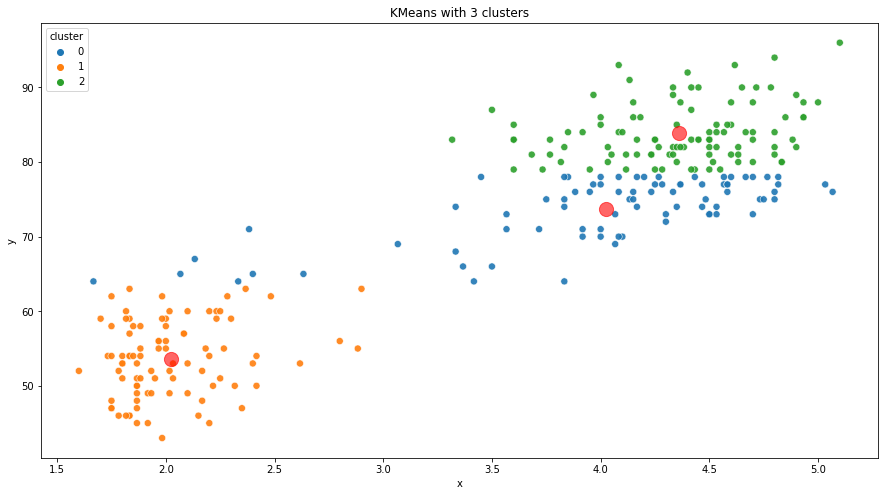

INFO:KMeans:Fitting KMeans with 4 clusters...
INFO:KMeans:Converged after 7 iterations


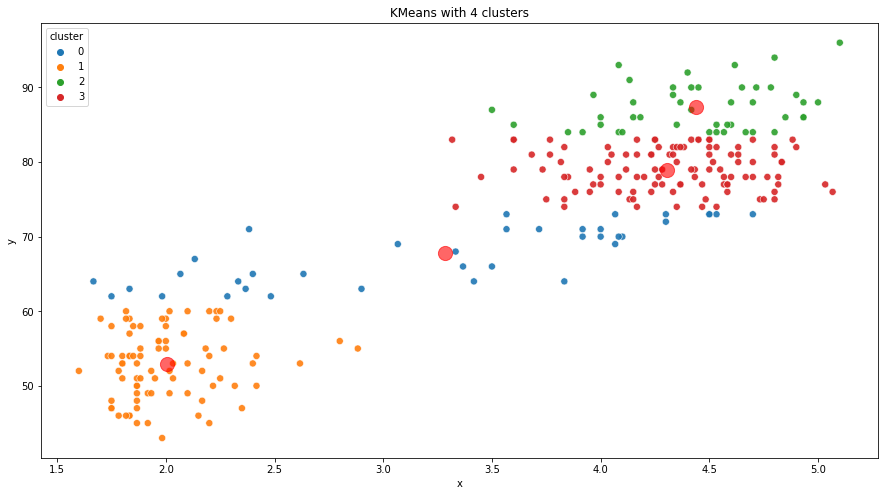

In [6]:
plot_kmeans(data.values, 2)
plot_kmeans(data.values, 3)
plot_kmeans(data.values, 4)

# Problem 2: Image Compression using K-means Clustering

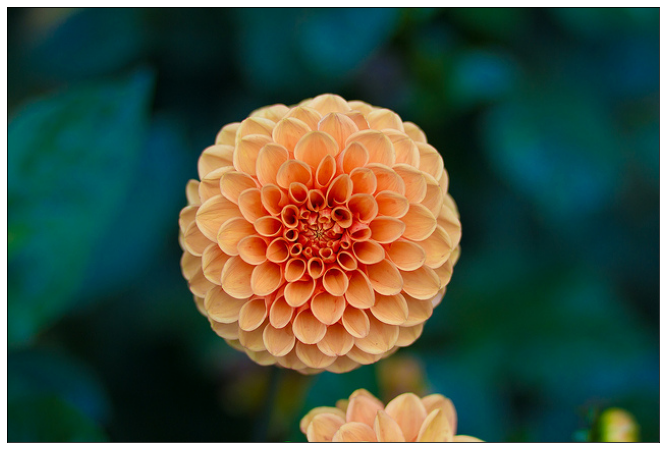

In [7]:
flower = load_sample_image("flower.jpg")

plt.figure(figsize=(20, 8))
ax = plt.axes(xticks=[], yticks=[])

ax.imshow(flower)
plt.show()


In [8]:
flower.shape

(427, 640, 3)

In [9]:
image_data = flower / 255.0
image_data = image_data.reshape(427 * 640, 3)
image_data.shape

(273280, 3)

In [10]:
image_data


array([[0.00784314, 0.0745098 , 0.05098039],
       [0.01176471, 0.07058824, 0.05098039],
       [0.02745098, 0.07843137, 0.05098039],
       ...,
       [0.02745098, 0.18039216, 0.10980392],
       [0.03137255, 0.17647059, 0.10980392],
       [0.03529412, 0.16862745, 0.10588235]])

In [11]:
image_kmeans = KMeans(n_clusters=16, max_iter=200, random_state=420, debug=False)
image_kmeans.fit(image_data)

new_colors = image_kmeans.cluster_centers_[image_kmeans.predict(image_data)]


INFO:KMeans:Fitting KMeans with 16 clusters...
INFO:KMeans:Converged after 108 iterations


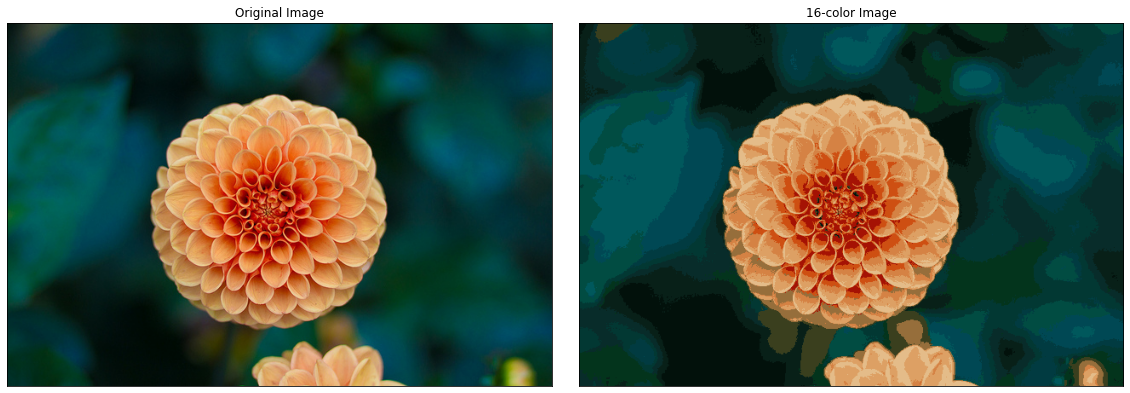

In [12]:
flower_recolored = new_colors.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(20, 8), subplot_kw=dict(xticks=[], yticks=[]))

fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title("Original Image")

ax[1].imshow(flower_recolored)
ax[1].set_title("16-color Image")

plt.show()


As we can see, the custom implementation of the K-Means algorithm is able to cluster the RGB points from the full color space to a 16-bit color space. Although there is a considerable loss of quality, the image is still recognizable. 

However, the custom implementation can be improved by:
- Using a better initialization method for the centroids, such as the K-Means++ algorithm.
- Adding a batch update method to the algorithm, which would update the centroids using a subset of random data points at each iteration. This would make the algorithm more scalable to large datasets.

# Problem 3: Gaussian Mixture Models (GMM)

A Gaussian mixture model assumes that the data is generated from $K$ Gaussian distributions with parameters unknown in advance. The model has the following parameters:
- $\pi_k$: the mixing coefficient for the $k$-th Gaussian component, where $\pi_k \geq 0$ and $\sum_{k=1}^{K} \pi_k = 1$.
- $\mu_k$: the mean of the $k$-th Gaussian component.
- $\Sigma_k$: the covariance matrix of the $k$-th Gaussian component.

The probability density function (pdf) of a Gaussian mixture model is given by:
$$
\begin{align*}
p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)
\end{align*}
$$

where $\mathcal{N}(x | \mu_k, \Sigma_k)$ is the pdf of the $k$-th Gaussian component.

Initially, the means and covariances of the Gaussian components can be initialized either randomly or using prior knowledge (maybe from K-Means clustering). The mixing coefficients can be initialized uniformly, i.e., $\pi_k = \frac{1}{K}$ for all $k$

The parameters of the Gaussian mixture model can be estimated using the Expectation-Maximization (EM) algorithm. The EM algorithm is an iterative algorithm that alternates between the following two steps:

## E-step (Expectation step)
First, we compute the posterior probability of the latent variables (i.e., the cluster assignments) given the current parameter estimates. This step involves generating a multivariate Gaussian distribution for each component (using the current parameters) and then using these distributions to compute the probability that each data point belongs to each component. 

This gives us the posterior probability of the latent variables given the data and the current parameter estimates.

$$
\begin{align*}
\gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_n | \mu_j, \Sigma_j)}
\end{align*}
$$

## M-step (Maximization step)
Once we have an estimate, we can setup a Lagrangian function to maximize the likelihood of the data given the current parameter estimates. This step involves updating the parameters to maximize the expected log-likelihood found in the E-step. Skipping the calculus, the update equations are:

$$
\begin{align*}
\pi_k &= \frac{1}{N} \sum_{n=1}^{N} \gamma(z_{nk}) \\
\mu_k &= \frac{\sum_{n=1}^{N} \gamma(z_{nk}) x_n}{\sum_{n=1}^{N} \gamma(z_{nk})} \\
\Sigma_k &= \frac{\sum_{n=1}^{N} \gamma(z_{nk}) (x_n - \mu_k)(x_n - \mu_k)^T}{\sum_{n=1}^{N} \gamma(z_{nk})}
\end{align*}
$$

The EM algorithm continues to iterate between the two steps until the parameters converge. The convergence is defined by the change in the log-likelihood of the data, which is guaranteed to increase at each iteration. 

## Log-likelihood
The log-likelihood of the data given the parameters of the model is given by:
$$
\begin{align*}
\ln p(X | \pi, \mu, \Sigma) = \sum_{n=1}^{N} \ln \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k) \right)
\end{align*}
$$

Note that the logarithm component of the above is already calculated in the E-step denominator, so we can reuse it for efficiency.

Thus, if the log-likelihood does not change significantly between iterations, we can stop the algorithm and return the parameters, which are the maximum likelihood estimates of the model and can be used to assign cluster labels to the data.

In [13]:
class GaussianMixture:
    """
    A Gaussian Mixture Model (GMM) implementation using the Expectation-Maximization (EM) algorithm.

    Parameters
    ----------
    n_components : int, default=2
        The number of mixture components.
    max_iter : int, default=100
        The maximum number of iterations to perform.
    tol : float, default=1e-3
        The convergence threshold. EM iterations will stop when the lower bound average gain is below this threshold.
    random_state : int, default=42
        Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.
    debug : bool, default=False
        If True, debug information will be logged.

    Attributes
    ----------
    weights : ndarray of shape (n_components,)
        The weights of each mixture components.
    means : ndarray of shape (n_components, n_features)
        The mean of each mixture component.
    covariances : ndarray of shape (n_components, n_features, n_features)
        The covariance matrix of each mixture component.
    log_likelihood : float
        The log likelihood of the model.
    """

    def __init__(
        self, n_components=2, max_iter=100, tol=1e-3, random_state=42, debug=False
    ):
        """
        Initializes the Gaussian Mixture Model.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

        self.random_state = random_state
        self.random = np.random.RandomState(self.random_state)

        self._logger = logging.getLogger(self.__class__.__name__)
        self._logger.setLevel(logging.DEBUG if debug else logging.INFO)

        self.weights = None
        self.means = None
        self.covariances = None
        self.log_likelihood = -np.inf

    def _initialize_parameters(self, X):
        """
        Initializes the model parameters.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.
        """
        random_idx = self.random.choice(X.shape[0], self.n_components, replace=False)
        self.means = X[random_idx]
        self.covariances = np.tile(np.diag(X.std(axis=0)), (self.n_components, 1, 1))
        self.weights = np.full(self.n_components, 1 / self.n_components)

    def _e_step(self, X):
        """
        Performs the expectation step of the EM algorithm.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.

        Returns
        -------
        gamma : ndarray of shape (n_samples, n_components)
            The responsibilities of each mixture component for each observation.
        totals : ndarray of shape (n_samples,)
            The total probability of each observation.
        """
        pdfs = np.zeros((X.shape[0], self.n_components))

        for i in range(self.n_components):
            rv = multivariate_normal(self.means[i], self.covariances[i])
            pdfs[:, i] = self.weights[i] * rv.pdf(X)

        totals = pdfs.sum(axis=1)

        gamma = pdfs / totals[:, np.newaxis]

        return gamma, totals

    def _m_step(self, X, gamma):
        """
        Performs the maximization step of the EM algorithm.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.
        gamma : ndarray of shape (n_samples, n_components)
            The responsibilities of each mixture component for each observation.
        """
        num_samples_i = gamma.sum(axis=0)

        self.weights = num_samples_i / X.shape[0]
        self.means = np.dot(gamma.T, X) / num_samples_i[:, np.newaxis]

        for i in range(self.n_components):
            diff = X - self.means[i]
            self.covariances[i] = np.dot(gamma[:, i] * diff.T, diff) / num_samples_i[i]

    def _calculate_log_likelihood(self, X, totals=None):
        """
        Calculates the log likelihood of the data given the model parameters.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.
        totals : ndarray of shape (n_samples,), optional
            The total probability of each observation. If not provided, it will be calculated.

        Returns
        -------
        log_likelihood : float
            The log likelihood of the data given the model.
        """
        if totals is not None:
            return np.sum(np.log(totals))

        return np.sum(
            np.log(
                np.sum(
                    [
                        self.weights[j]
                        * multivariate_normal(self.means[j], self.covariances[j]).pdf(X)
                        for j in range(self.n_components)
                    ],
                    axis=0,
                )
            )
        )

    def fit(self, X):
        """
        Fits the model to the data using the EM algorithm.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.
        """
        self._logger.info(
            f"Fitting Gaussian Mixture with {self.n_components} components..."
        )

        self._initialize_parameters(X)

        for iter in range(self.max_iter):
            self._logger.debug(f"Iteration {iter + 1}")

            old_log_likelihood = self.log_likelihood

            gamma, totals = self._e_step(X)
            self._m_step(X, gamma)

            self.log_likelihood = self._calculate_log_likelihood(X, totals)

            if np.abs(self.log_likelihood - old_log_likelihood) < self.tol:
                self._logger.info(f"Converged after {iter + 1} iterations")
                break

    def predict_proba(self, X):
        """
        Predicts the probabilities of each mixture component for each observation.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.

        Returns
        -------
        probabilities : ndarray of shape (n_samples, n_components)
            The probabilities of each mixture component for each observation.
        """
        likelihood = np.array(
            [
                multivariate_normal(self.means[j], self.covariances[j]).pdf(X)
                for j in range(self.n_components)
            ]
        ).T

        weighted_likelihood = self.weights * likelihood

        return weighted_likelihood / weighted_likelihood.sum(axis=1)[:, np.newaxis]

    def predict(self, X):
        """
        Predicts the most likely mixture component for each observation.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.

        Returns
        -------
        predictions : ndarray of shape (n_samples,)
            The predicted mixture component for each observation.
        """
        return np.argmax(self.predict_proba(X), axis=1)


In [14]:
def plot_gmm(data, n_components, max_iter=100, random_state=42, debug=False):
    """
    Plots a Gaussian Mixture Model (GMM) clustering and returns the fitted model.

    Parameters
    ----------
    data : array-like of shape (n_samples, n_features)
        The input data to fit the GMM to.
    n_components : int
        The number of mixture components.
    max_iter : int, default=100
        The maximum number of iterations to perform.
    random_state : int, default=42
        Controls the randomness of the algorithm.
    debug : bool, default=False
        If True, additional information will be printed for debugging purposes.

    Returns
    -------
    gmm : GaussianMixture object
        The fitted Gaussian Mixture model.
    """
    gmm = GaussianMixture(
        n_components=n_components,
        max_iter=max_iter,
        random_state=random_state,
        debug=debug,
    )

    gmm.fit(data)

    data = pd.DataFrame(data, columns=["x", "y"])

    data["cluster"] = gmm.predict(data)

    plt.figure(figsize=(15, 8))

    sns.scatterplot(
        data=data, x="x", y="y", hue="cluster", palette="tab10", s=50, alpha=0.9
    )

    plt.title(f"Gaussian Mixture Model with {n_components} components")

    plt.show()

    return gmm


INFO:GaussianMixture:Fitting Gaussian Mixture with 2 components...
INFO:GaussianMixture:Converged after 8 iterations


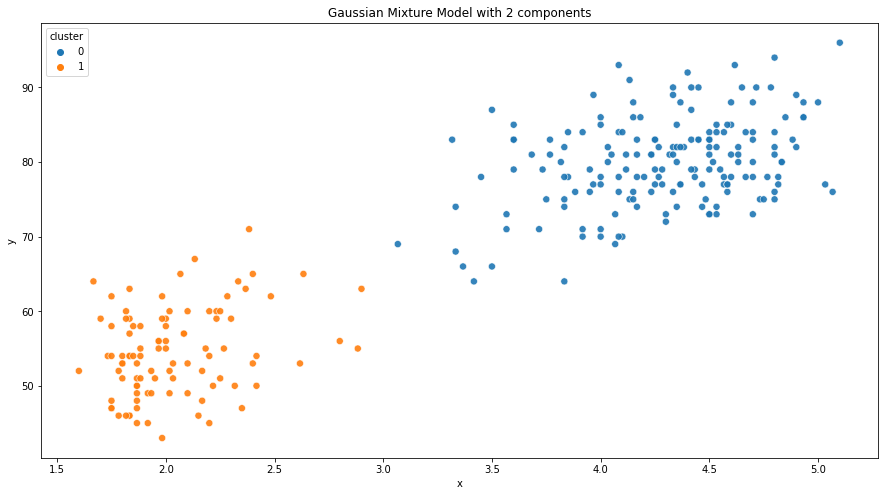

INFO:GaussianMixture:Fitting Gaussian Mixture with 3 components...
INFO:GaussianMixture:Converged after 72 iterations


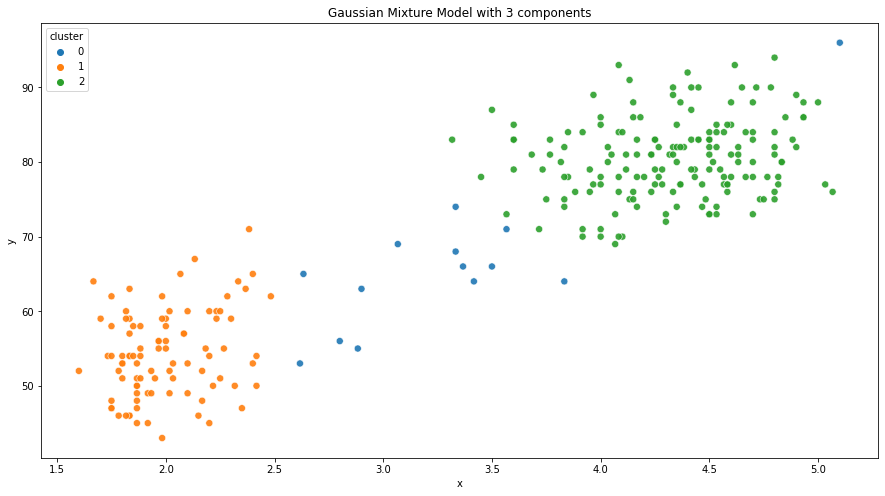

INFO:GaussianMixture:Fitting Gaussian Mixture with 4 components...
INFO:GaussianMixture:Converged after 106 iterations


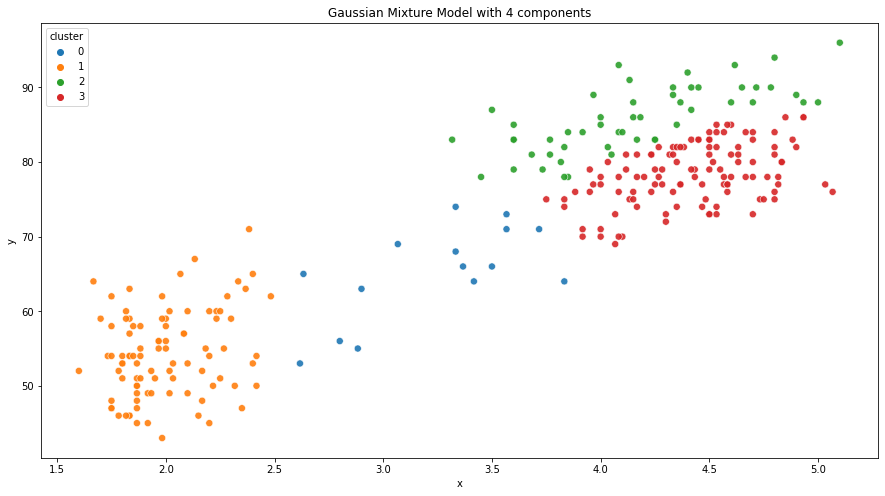

In [15]:
gmm_2 = plot_gmm(data.values, 2, max_iter=1000)
gmm_3 = plot_gmm(data.values, 3, max_iter=1000)
gmm_4 = plot_gmm(data.values, 4, max_iter=1000)